In [2]:
import os
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import json
import csv
import pandas as pd
import seaborn as sns

In [3]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [4]:
ROOT = '/mnt/data0/lucy/manosphere/'
SUBS = ROOT + 'data/submissions/'
SUB_META = ROOT + 'data/subreddits.txt'
LOGS = ROOT + 'logs/'

# Data

- Reddit submissions and comments
- Seven external forums: avfm, red_pill_talk, pua_forum, the_attraction, incels, mgtow, rooshv

Manoel's paper no longer includes Criticism and Health, but we had initially filtered it into our folder of manosphere Reddit comments and submissions. This means extra care should be given to exclude these in downstream tasks. 

Community categories are Incels, MGTOW, PUA, MRA, TRP. We added Femcels and FDS, which are subreddits. 

There should be **51** Reddit subreddits from the original Manosphere paper: 
- PUA (7)
- Incels (18)
- TRP (12)
- MRA (11)
- MGTOW (3)

Our differences is that we recategorize `r/Truefemcels` into Femcels, so we have 17 incels subreddits, after removing 5 banned subreddits from the initial total of 22.

In [7]:
# Get subreddit categories 
categories = defaultdict(str)
categories_rev = defaultdict(list)
with open(SUB_META, 'r') as infile: 
    reader = csv.DictReader(infile)
    for row in reader: 
        name = row['Subreddit'].strip().lower()
        if name.startswith('/r/'): name = name[3:]
        if name.startswith('r/'): name = name[2:]
        if name.endswith('/'): name = name[:-1]
        categories[name] = row['Category after majority agreement']
        categories_rev[row['Category after majority agreement']].append(name)

In [8]:
# The names of the categories we have
categories_rev.keys()

dict_keys(['TRP', 'MRA', 'PUA', 'Incels', 'Criticism', 'Health', 'MGTOW', 'Femcels', 'FDS'])

In [9]:
for cat in categories_rev: 
    if cat != 'Criticism' and cat != 'Health': 
        print(cat, len(categories_rev[cat]))

TRP 12
MRA 11
PUA 7
Incels 22
MGTOW 3
Femcels 4
FDS 6


### Submissions

Some subreddits in the list provided by Manoel are missing in the dataset.

There are comments for `r/philosophyofrape` but no submissions. 

Two major events are plotted as well: the **September 2018 quarantine** and the **banning of r/incels in November 2017**.

In [15]:
with open(LOGS + 'submission_counts.json', 'r') as infile:
    sr_month = json.load(infile)

In [16]:
# Get subreddits missing from data 
all_srs = set(categories.keys()) 
found_srs = set()
banned = set(['malecels', '1ncels', 'incelspurgatory', 'incelbrotherhood', 'lonelynonviolentmen'])
for month in sr_month: 
    found_srs.update(sr_month[month].keys())
print(all_srs - found_srs - banned)
print(found_srs - all_srs)

{'philosophyofrape'}
set()


In [17]:
d = {'subreddit': [], 'category': [], 'month': [], 'count': []}
for month in sr_month: 
    for sr in sr_month[month]: 
        if categories[sr] != 'Health' and categories[sr] != 'Criticism':
            d['count'].append(sr_month[month][sr])
            d['category'].append(categories[sr])
            d['subreddit'].append(sr)
            d['month'].append(dt.datetime.strptime(month,'%Y-%m').date())
df = pd.DataFrame(data=d)

In [18]:
df

,subreddit,category,month,count
0,mensrights,MRA,2009-07-01,285
1,seduction,PUA,2009-07-01,22
2,foreveralone,Incels,2012-01-01,1367
3,seduction,PUA,2012-01-01,1480
4,foreveralonedating,Incels,2012-01-01,208
...,...,...,...,...
3183,geotrp,TRP,2015-06-01,2
3184,mrref,MRA,2015-06-01,2
3185,foreveraloneteens,Incels,2015-06-01,1
3186,mensrightslaw,MRA,2015-06-01,1


In [19]:
print("START:", min(df['month']))
print("END:", max(df['month']))

START: 2008-03-01
END: 2020-04-01


In [25]:
df_sum = df.groupby(['category', 'month']).sum().reset_index()
df_sum

,category,month,count
0,FDS,2019-02-01,3
1,FDS,2019-03-01,39
2,FDS,2019-04-01,89
3,FDS,2019-05-01,303
4,FDS,2019-06-01,325
...,...,...,...
628,TRP,2019-12-01,3833
629,TRP,2020-01-01,3791
630,TRP,2020-02-01,3233
631,TRP,2020-03-01,3320


/mnt/data0/lucy/anaconda3/envs/bert/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


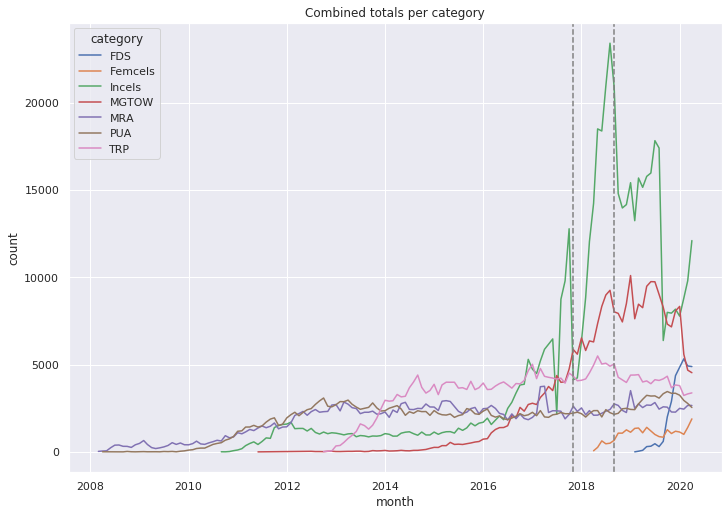

In [26]:
g = sns.lineplot(x="month", y="count", hue="category", data=df_sum)
plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color="gray")
plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
plt.title("Combined totals per category")
plt.show()

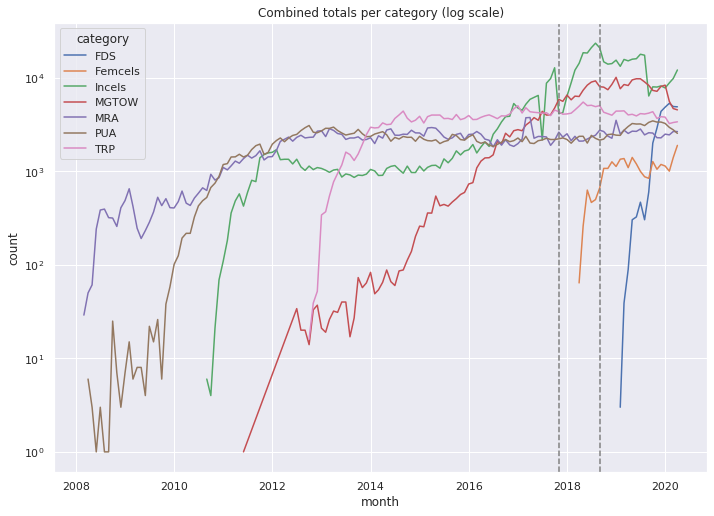

In [27]:
g = sns.lineplot(x="month", y="count", hue="category", data=df_sum)
g.set_yscale("log")
plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color="gray")
plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
plt.title("Combined totals per category (log scale)")
plt.show()

In [28]:
def plot_over_time(cat, quarantine=False):
    cat_df = df[df['category'] == cat]
    sns.lineplot(x="month", y="count", hue="subreddit", data=cat_df)
    plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color='gray')
    if quarantine: 
        plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(cat)
    plt.show()

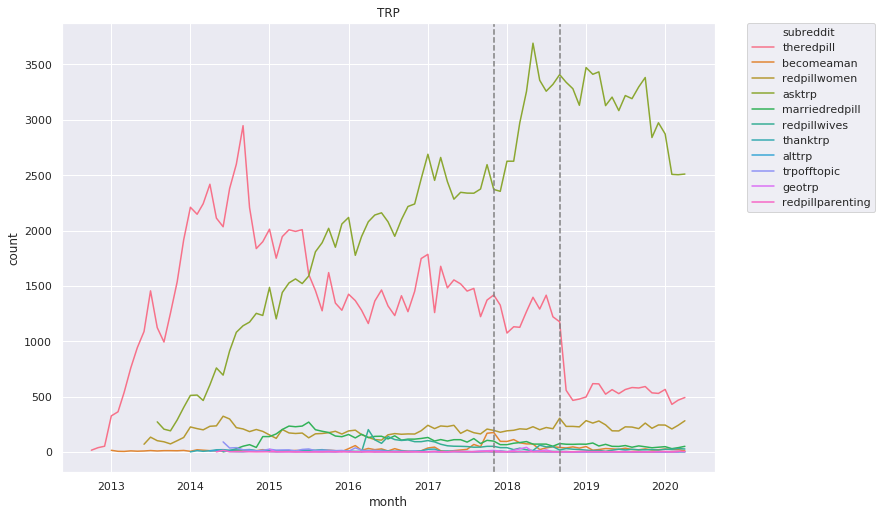

In [20]:
plot_over_time('TRP', quarantine=True)

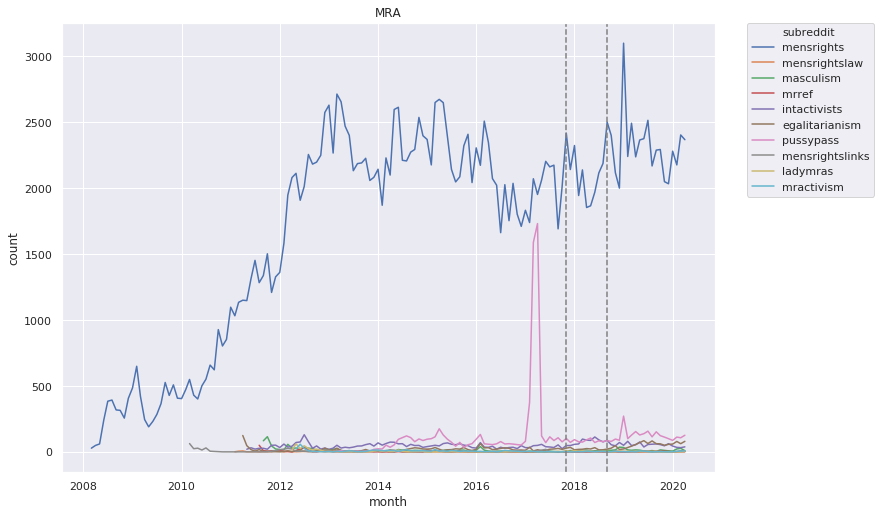

In [21]:
plot_over_time('MRA', quarantine=True)

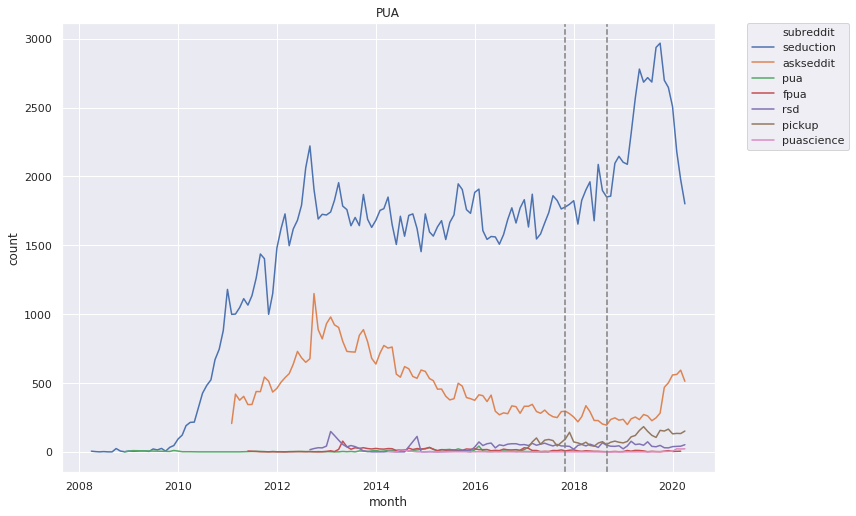

In [22]:
plot_over_time('PUA', quarantine=True)

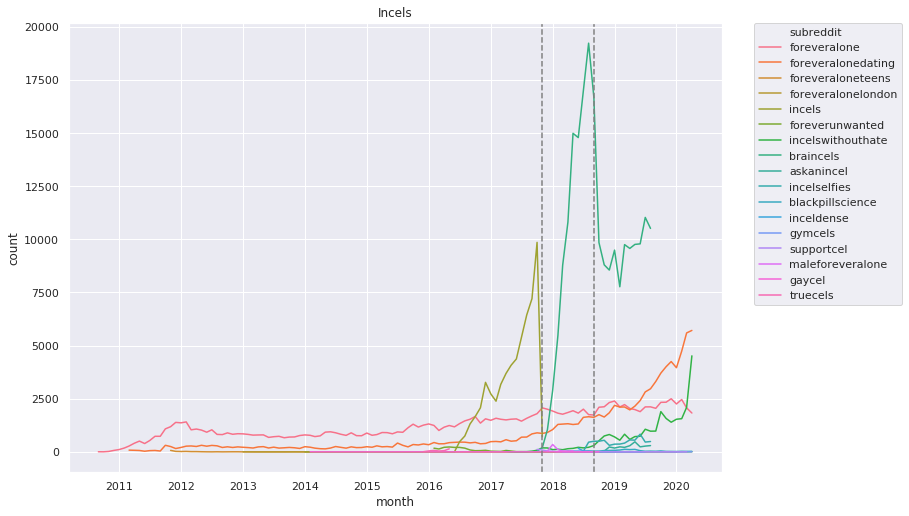

In [23]:
plot_over_time('Incels', quarantine=True)

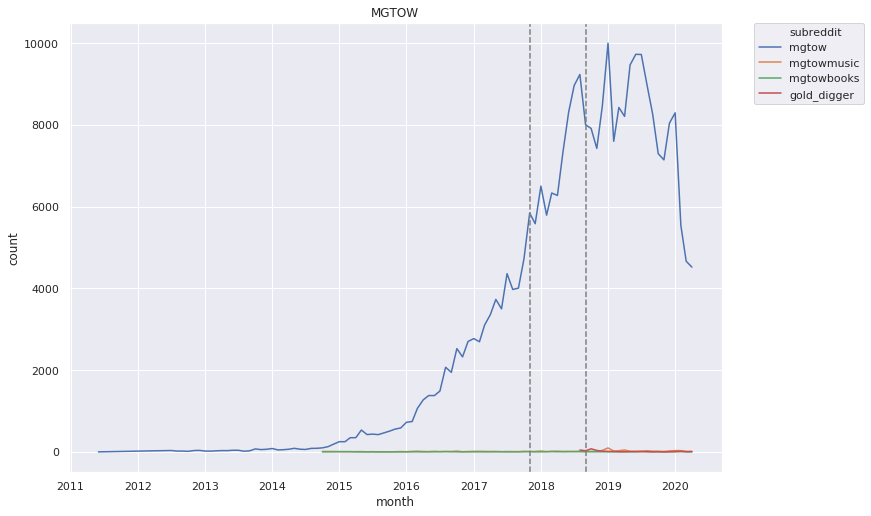

In [26]:
plot_over_time('MGTOW', quarantine=True)

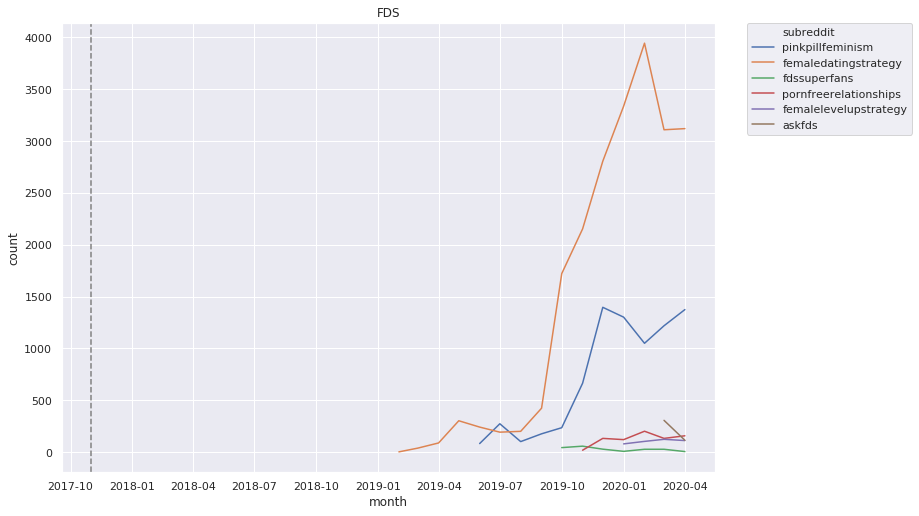

In [27]:
plot_over_time('FDS')

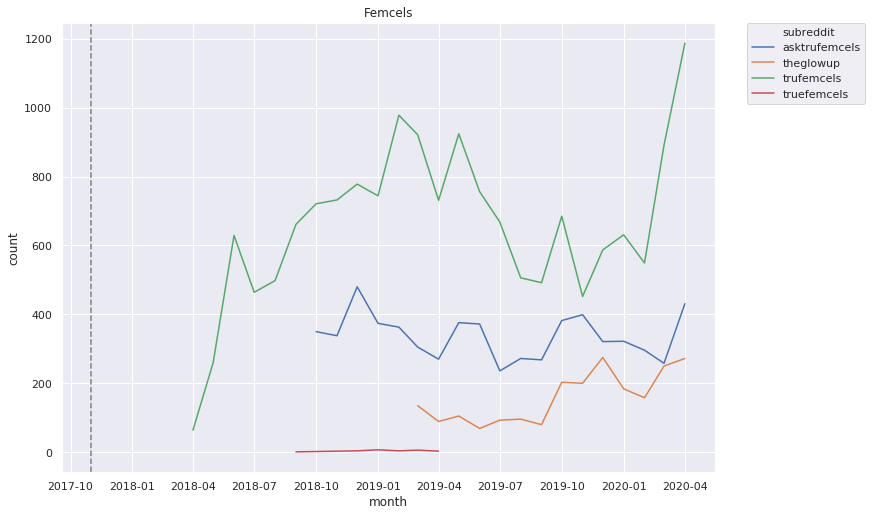

In [28]:
plot_over_time('Femcels')

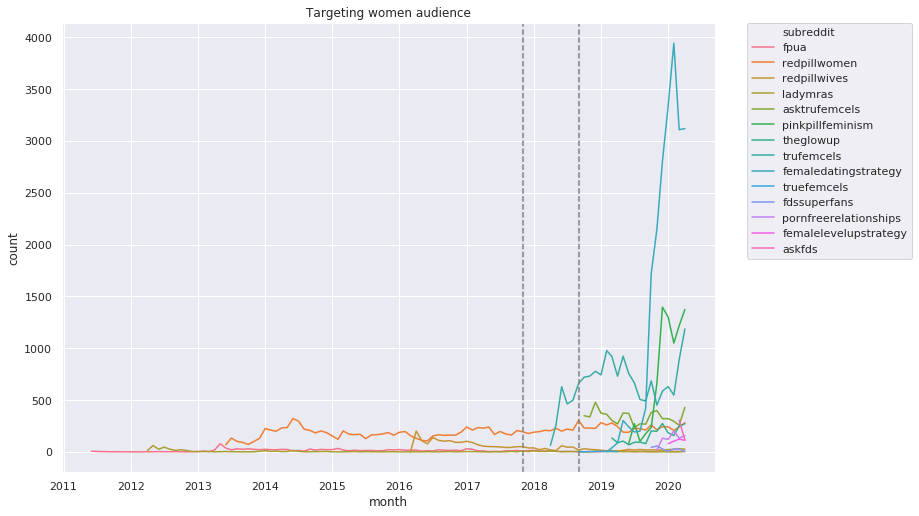

In [29]:
women = set(['redpillwives', 'redpillwomen', 'ladymras', 'truefemcels', 'fpua'])
women_df = df.loc[(df['subreddit'].isin(women)) | (df['category'] == 'FDS') | (df['category'] == 'Femcels')]
sns.lineplot(x="month", y="count", hue="subreddit", data=women_df)
plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color='gray')
plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Targeting women audience")
plt.show()

### Comments

In [5]:
with open(LOGS + 'comment_counts.json', 'r') as infile:
    sr_coms = json.load(infile)

In [10]:
com_d = {'subreddit': [], 'category': [], 'month': [], 'comment_count': []}
for month in sr_coms: 
    for sr in sr_coms[month]: 
        if categories[sr] != 'Health' and categories[sr] != 'Criticism': 
            com_d['comment_count'].append(sr_coms[month][sr])
            com_d['category'].append(categories[sr])
            com_d['subreddit'].append(sr)
            com_d['month'].append(dt.datetime.strptime(month,'%Y-%m').date())
com_df = pd.DataFrame(data=com_d)

In [11]:
com_df

,subreddit,category,month,comment_count
0,theredpill,TRP,2016-03-01,46554
1,seduction,PUA,2016-03-01,10641
2,askseddit,PUA,2016-03-01,2102
3,intactivists,MRA,2016-03-01,133
4,foreverunwanted,Incels,2016-03-01,3087
...,...,...,...,...
2875,masculism,MRA,2012-08-01,324
2876,mgtow,MGTOW,2012-08-01,24
2877,foreveraloneteens,Incels,2012-08-01,53
2878,pua,PUA,2012-08-01,10


In [14]:
print("START:", min(com_df['month']))
print("END:", max(com_df['month']))

START: 2008-03-01
END: 2019-12-01


In [32]:
df_sum_com = com_df.groupby(['category', 'month']).sum().reset_index()
df_sum_com

,category,month,comment_count
0,FDS,2019-02-01,1
1,FDS,2019-03-01,69
2,FDS,2019-04-01,40
3,FDS,2019-05-01,1518
4,FDS,2019-06-01,1351
...,...,...,...
596,TRP,2019-08-01,59559
597,TRP,2019-09-01,60956
598,TRP,2019-10-01,64170
599,TRP,2019-11-01,54612


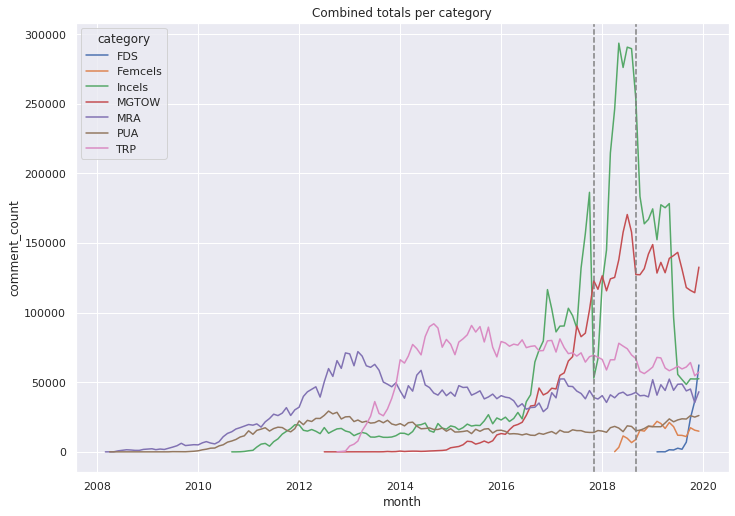

In [33]:
g = sns.lineplot(x="month", y="comment_count", hue="category", data=df_sum_com)
plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color="gray")
plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
plt.title("Combined totals per category")
plt.show()

In [34]:
all_df = pd.merge(df_sum, df_sum_com, on=['month', 'category'])
all_df['engagement'] = all_df['comment_count'] / all_df['count']
all_df

,category,month,count,comment_count,engagement
0,FDS,2019-02-01,3,1,0.333333
1,FDS,2019-03-01,39,69,1.769231
2,FDS,2019-04-01,89,40,0.449438
3,FDS,2019-05-01,303,1518,5.009901
4,FDS,2019-06-01,325,1351,4.156923
...,...,...,...,...,...
596,TRP,2019-08-01,4091,59559,14.558543
597,TRP,2019-09-01,4182,60956,14.575801
598,TRP,2019-10-01,4333,64170,14.809601
599,TRP,2019-11-01,3670,54612,14.880654


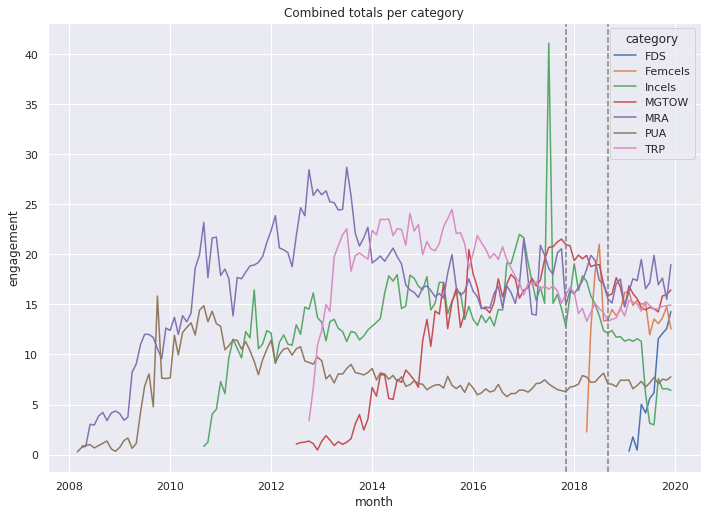

In [35]:
g = sns.lineplot(x="month", y="engagement", hue="category", data=all_df)
plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color="gray")
plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
plt.title("Combined totals per category")
plt.show()

In [37]:
all_cat_df = all_df.groupby(['category']).sum()
all_cat_df['coms_n_subs'] = all_cat_df['count'] + all_cat_df['comment_count']
all_cat_df

,count,comment_count,engagement,coms_n_subs
category,,,,
FDS,11392,137469,74.061438,148861
Femcels,19732,287877,296.203751,307609
Incels,514104,6591237,1500.042313,7105341
MGTOW,268514,4567011,1116.571935,4835525
MRA,261565,4813720,2374.210520,5075285
PUA,254421,2006110,1065.177537,2260531
TRP,304778,5491807,1559.828154,5796585


### Forums

We removed duplicate posts from forums to produce a cleaner version. 

There is a forum `rooshv`, that has posts without datetime values. There is also one date for `the_attraction` that is from 1970, which is likely a mistake. 

We remove `love_shy` from consideration like Manoel did in his paper since its posts required registration to view. 

In [20]:
with open(LOGS + 'forum_count.json', 'r') as infile:
    forum_month = json.load(infile)
with open(LOGS + 'old_forum_count.json', 'r') as infile:
    old_forum_month = json.load(infile)

In [6]:
# compare old and new counts (after removing duplicates)
for month in forum_month: 
    for forum in forum_month[month]: 
        if forum_month[month][forum] != old_forum_month[month][forum]:
            print(month, forum, forum_month[month][forum], old_forum_month[month][forum])

2007-05 the_attraction 9645 9649
2013-08 the_attraction 2707 2708
2013-09 the_attraction 2102 2103
2012-05 the_attraction 5038 5040
2012-11 pua_forum 8303 8304
2012-10 the_attraction 3952 3953
2008-07 the_attraction 11466 11473
2018-07 incels 129415 129476
2018-05 incels 163698 163820
2017-08 red_pill_talk 3522 3523
2014-08 red_pill_talk 50855 50857
2014-09 red_pill_talk 40868 40876
2019-03 the_attraction 90 91
2015-05 red_pill_talk 59891 59894
2015-03 red_pill_talk 45875 45876
2007-06 the_attraction 8983 8988
2014-10 red_pill_talk 47505 47510
2014-07 red_pill_talk 49642 49649
2013-05 the_attraction 2867 2868
2014-06 red_pill_talk 46083 46139
2013-01 the_attraction 5154 5156
2012-09 the_attraction 3670 3672
2018-03 incels 139061 139122


In [21]:
forum_d = {'forum': [], 'month': [], 'comment_count': []}
nones = Counter()
for month in forum_month: 
    for forum in forum_month[month]: 
        if forum == 'love_shy': continue
        if month == 'None-None': 
            nones[forum] += forum_month[month][forum]
            continue
        forum_d['comment_count'].append(forum_month[month][forum])
        forum_d['forum'].append(forum)
        forum_d['month'].append(dt.datetime.strptime(month,'%Y-%m').date())
forum_df = pd.DataFrame(data=forum_d)
print(nones)

Counter({'rooshv': 2330})


In [22]:
forum_df

,forum,month,comment_count
0,the_attraction,2007-05-01,9645
1,pua_forum,2007-05-01,1478
2,the_attraction,2007-09-01,13680
3,pua_forum,2007-09-01,10697
4,the_attraction,2012-06-01,5428
...,...,...,...
675,avfm,2016-04-01,2734
676,red_pill_talk,2016-04-01,8850
677,pua_forum,2016-04-01,3082
678,the_attraction,1970-01-01,1


In [25]:
outliers = forum_df[forum_df['month'] < dt.datetime.strptime('2005-01','%Y-%m').date()]
outliers

,forum,month,comment_count
678,the_attraction,1970-01-01,1


In [26]:
forum_df = forum_df[forum_df['month'] >= dt.datetime.strptime('2005-01','%Y-%m').date()]

In [27]:
print("START:", min(forum_df['month']))
print("END:", max(forum_df['month']))

START: 2005-11-01
END: 2019-06-01


/mnt/data0/lucy/anaconda3/envs/bert/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


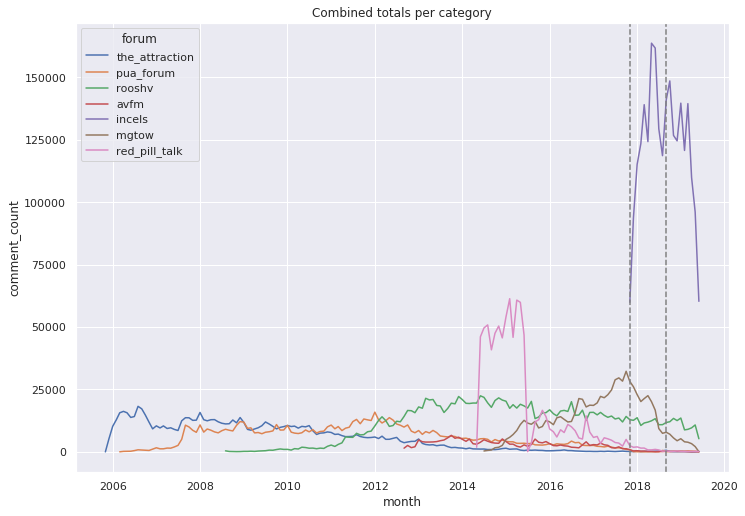

In [11]:
g = sns.lineplot(x="month", y="comment_count", hue="forum", data=forum_df)
plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color="gray")
plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
plt.title("Combined totals per category")
plt.show()

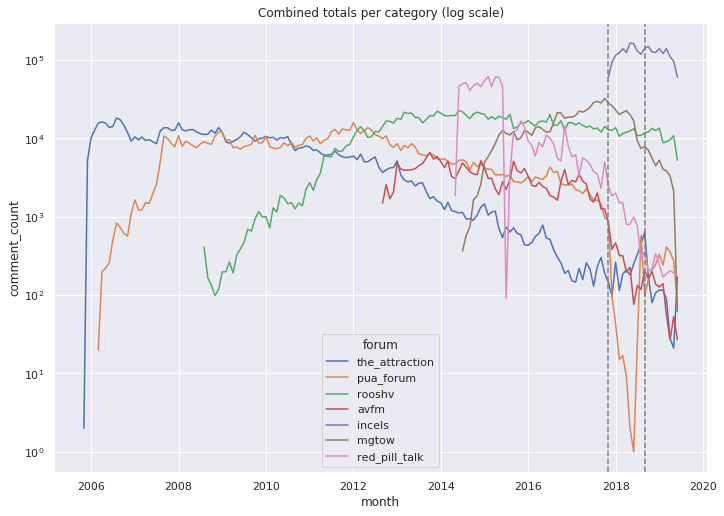

In [12]:
g = sns.lineplot(x="month", y="comment_count", hue="forum", data=forum_df)
g.set_yscale("log")
plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color="gray")
plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
plt.title("Combined totals per category (log scale)")
plt.show()

### Big shifts and changes

For some subreddits, look at major communities where there is a 90% decrease in posts, or a more than 500% increase. 

In [49]:
sr_df = pd.merge(df, com_df, on=['month', 'category', 'subreddit'])
sr_df['post_total'] = sr_df['count'] + sr_df['comment_count']
sr_df

,subreddit,category,month,count,comment_count,post_total
0,mensrights,MRA,2009-07-01,285,3427,3712
1,seduction,PUA,2009-07-01,22,151,173
2,foreveralone,Incels,2012-01-01,1367,17741,19108
3,seduction,PUA,2012-01-01,1480,19626,21106
4,foreveralonedating,Incels,2012-01-01,208,1513,1721
...,...,...,...,...,...,...
2754,ladymras,MRA,2015-06-01,1,1,2
2755,egalitarianism,MRA,2015-06-01,17,355,372
2756,mensrightslinks,MRA,2015-06-01,1,1,2
2757,geotrp,TRP,2015-06-01,2,14,16


In [50]:
sr_dates = sorted(set(sr_df['month'].tolist()))
srs = sorted(set(sr_df['subreddit'].tolist()))
sr_over_time = defaultdict(list) # keys are sr, values are a chronological list
for month in sr_dates: 
    for sr in srs: 
        month_f = str(month.year) + '-' + '{:02d}'.format(month.month) 
        t = 0
        if sr in sr_coms[month_f]: 
            t += sr_coms[month_f][sr]
        if sr in sr_month[month_f]:
            t += sr_month[month_f][sr]
        sr_over_time[sr].append(t)

In [51]:
for sr in sr_over_time: 
    prev_c = None
    for i, c in enumerate(sr_over_time[sr]): 
        if prev_c is not None: 
            if c <= 0.1*prev_c and not (c <= 100 and prev_c <= 100): 
                print(sr, sr_dates[i], "DECREASE:", prev_c, c)
            if c >= 5*prev_c and not prev_c == 0 and not (c <= 100 and prev_c <= 100): 
                print(sr, sr_dates[i], "INCREASE:", prev_c, c)
        prev_c = c

alttrp 2014-06-01 DECREASE: 105 2
askanincel 2018-12-01 INCREASE: 472 7213
askanincel 2019-11-01 DECREASE: 1195 0
becomeaman 2016-01-01 INCREASE: 34 200
blackpillscience 2018-04-01 INCREASE: 6 150
braincels 2017-11-01 INCREASE: 122 3758
braincels 2017-12-01 INCREASE: 3758 31743
braincels 2019-09-01 DECREASE: 10515 0
egalitarianism 2012-10-01 INCREASE: 18 140
femaledatingstrategy 2019-03-01 INCREASE: 4 108
femaledatingstrategy 2019-05-01 INCREASE: 129 1821
foreveralone 2010-11-01 INCREASE: 9 106
foreveralonedating 2011-10-01 INCREASE: 384 2545
fpua 2013-05-01 INCREASE: 98 1343
gymcels 2018-05-01 INCREASE: 12 299
incels 2016-07-01 INCREASE: 6 12474
incels 2017-11-01 DECREASE: 161843 10542
incels 2017-12-01 DECREASE: 10542 0
incelselfies 2018-08-01 INCREASE: 265 7382
incelselfies 2019-07-01 DECREASE: 8412 462
incelselfies 2019-09-01 DECREASE: 488 0
incelswithouthate 2017-08-01 INCREASE: 31 527
ladymras 2013-03-01 INCREASE: 38 373
ladymras 2013-04-01 DECREASE: 373 28
maleforeveralone 2018-

### Plots for a single community

In [61]:
def plot_over_time_reddit(sr):
    single_df = sr_df[sr_df['subreddit'] == sr]
    sns.lineplot(x="month", y="post_total", data=single_df)
    plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color='gray') 
    plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
    plt.title("Post total for a single subreddit: " + sr)
    plt.show()
def plot_over_time_forum(forum):
    g = sns.lineplot(x="month", y="comment_count", data=forum_df[forum_df['forum'] == forum])
    plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color="gray")
    plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
    plt.title("Combined totals per category")
    plt.show()

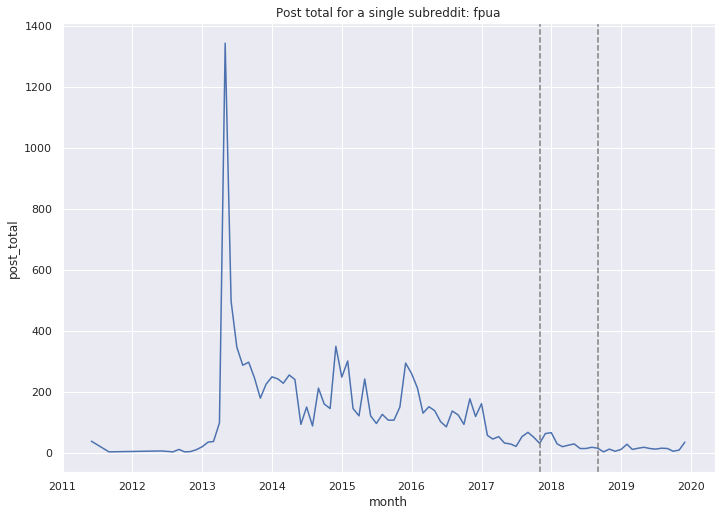

In [62]:
plot_over_time_reddit('fpua')

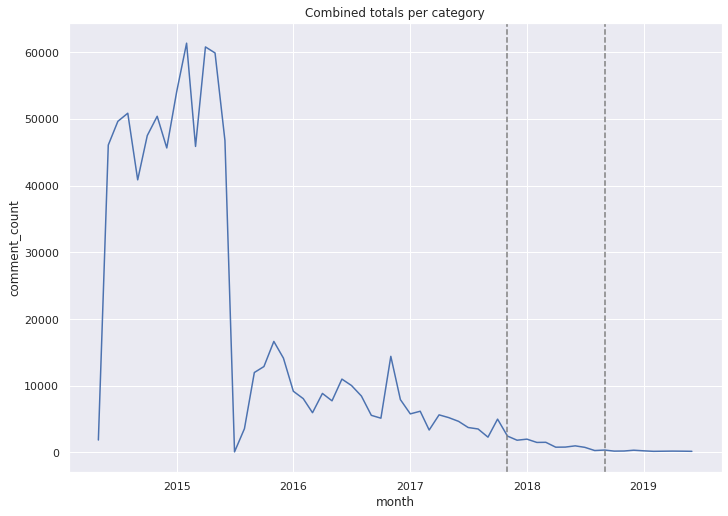

In [58]:
plot_over_time_forum('red_pill_talk')